In [1]:
import xarray as xr
import numpy as np
import cartopy
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from tqdm import tqdm
import h3

In [4]:
# pset_1 = xr.open_zarr('/nethome/sebil001/NEMO_Ensemble/Pensemble_001.zarr')
pset_1 = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_spacetime_001.zarr')

In [5]:
pset_1

<xarray.Dataset> Size: 81MB
Dimensions:     (trajectory: 6960, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 56kB 60 61 62 63 64 ... 7016 7017 7018 7019
Data variables:
    lat         (trajectory, obs) float64 20MB dask.array<chunksize=(6960, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 20MB dask.array<chunksize=(6960, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 20MB dask.array<chunksize=(6960, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 20MB dask.array<chunksize=(6960, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

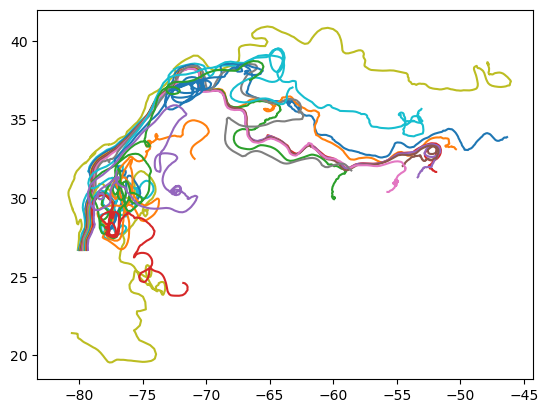

In [6]:
for i in range(45):
    plt.plot(pset_1.lon[i, :], pset_1.lat[i, :])

In [4]:
surface = pset_1.where(pset_1['z'] < 10)

In [5]:
domain_limits = [[-100, 0], [-10, 60]] # [lon_min, lon_max], [lat_min, lat_max]

/tmp/ipykernel_516137/946033018.py:6: RuntimeWarning: divide by zero encountered in log2
  plt.pcolormesh(x_, y_, -np.log2(h.T), cmap='Blues')


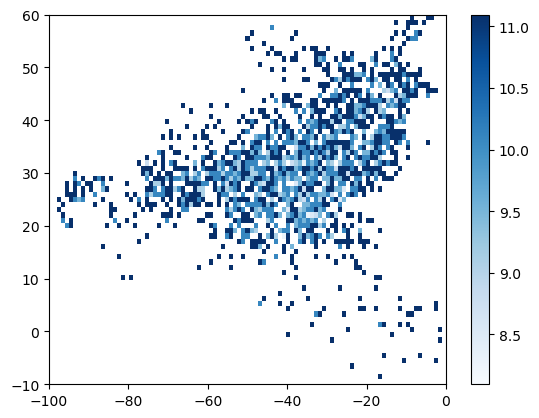

In [6]:
dt = -1
h, x_, y_ = np.histogram2d(surface.lon[:,dt], surface.lat[:,dt], bins=[99, 71], range=domain_limits, density=True)

h_i, _, _ = np.histogram2d(surface.lon[:,dt+1], surface.lat[:,dt+1], bins=[99, 71], range=domain_limits)

plt.pcolormesh(x_, y_, -np.log2(h.T), cmap='Blues')
plt.colorbar(label='')


In [7]:
# compute the entropy of the 2D histogram
h = h / np.sum(h)
h_i = h_i / np.sum(h_i)
h[h == 0] = 1
h_i[h_i == 0] = 1
entropy = -np.sum(h * np.log2(h))   # in bits
entropy_i = -np.sum(h_i * np.log2(h_i))   # in bits
print('Entropy:', entropy)
print('Entropy_i:', entropy_i)

Entropy: 10.10819092216956
Entropy_i: 11.621136113274643


In [8]:
def optbins_2D(data_x, data_y, maxM_x, maxM_y, domain_limits, minM=0):
    
    logp = np.zeros((maxM_x - 1 - minM, maxM_y - 1 - minM))
    N = len(data_x)
    
    for M_x in tqdm(range(minM, maxM_x)):
        for M_y in range(minM, maxM_y):
            M = M_x * M_y
            n, x_, y_ = np.histogram2d(data_x, data_y, bins=[M_x, M_y], 
                                       range=domain_limits, density=True)
            
            part1 = N * np.log(M) + gammaln(M / 2) - gammaln(N + M / 2)
            part2 = -M * gammaln(1 / 2) + np.sum(gammaln(n + 0.5))
            
            logp[M_x - 1 - minM, M_y - 1 - minM] =  part1 + part2
            
    return logp
    

In [9]:
dt = 0
logp_ = optbins_2D(surface.lon[:,dt], surface.lat[:,dt], 100, 100, domain_limits, minM=70)

100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


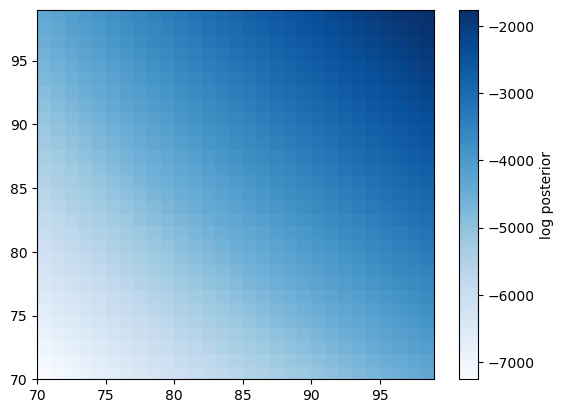

In [10]:
N_bins = np.arange(70, 100)
plt.pcolormesh(N_bins, N_bins, logp_.T, cmap='Blues')
plt.colorbar(label='log posterior')

In [22]:
def optbins(data, maxM):
    """
    Find the optimal number of bins for a one-dimensional data set using the
    posterior probability for the number of bins. This function performs a
    brute-force search over the number of bins in the given range.

    Parameters:
    - data: A one-dimensional array-like object of data points.
    - maxM: The maximum number of bins to consider.

    Returns:
    - optM: The optimal number of bins based on the posterior probability.

    Reference:
    K.H. Knuth. Optimal data-based binning for histograms and histogram-based 
    probability density models, Digital Signal Process. (2019)
    https://doi.org/10.1016/j.dsp.2019.102581

    Note:
    - The function assumes data is a one-dimensional array-like object.
    - This implementation uses equal width bins.
    """

    if np.ndim(data) > 1 or (np.ndim(data) == 1 and len(data.shape) > 1 and data.shape[0] > 1):
        raise ValueError('data dimensions must be (1,N) or a one-dimensional array-like object.')

    N = len(data)
    logp = np.zeros(maxM)
    
    for M in range(1, maxM + 1):
        # Bin the data (equal width bins)
        n, _ = np.histogram(data, bins=M) # n: counts, _: bin edges
        part1 = N * np.log(M) + gammaln(M / 2) - gammaln(N + M / 2)
        part2 = -M * gammaln(1 / 2) + np.sum(gammaln(n + 0.5))
        logp[M - 1] = part1 + part2

    # Find the number of bins with the maximum log posterior probability
    optM = np.argmax(logp) + 1  # Adding 1 because Python indexes from 0
    return optM


1. compare the pdf of particles released in known location to noise levels. If the noise is equal than the particle ensemble pdf. Loss of information

How to measure or quantify noise? 
...

In [2]:
# Assuming you have a list of lat, lon coordinates
latitudes = np.array([37.5, 37.6, 37.7])
longitudes = np.array([-122.4, -122.5, -122.6])

# Convert lat, lon to h3 index
h3_indices = [h3.geo_to_h3(lat, lon, resolution=7) for lat, lon in zip(latitudes, longitudes)]

# Now you can bin your data using these indices
# For example, to count the number of particles in each bin:
bins = np.unique(h3_indices, return_counts=True)

In [3]:
bins

(array(['872830969ffffff', '87283428dffffff', '8728342d9ffffff'],
       dtype='<U15'),
 array([1, 1, 1]))

In [4]:
import folium

ModuleNotFoundError: No module named 'folium'